In [7]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import pandas as pd
import pickle
import cmcrameri.cm as cmc

In [8]:
def get_scardec_stf(scardec_name, wanted_type = 'fctopt'):
    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    time = np.array(time)
    return momentrate, time

In [9]:
def get_ye_stf(ye_name):
    data_path = '/home/earthquakes1/homes/Rebecca/phd/stf/data/Ye_et_al_2016/'
    momentrate = []
    time = []

    with open(data_path + str(ye_name), 'r') as f:
        data = f.readlines()
        for line in data:
            line = line.strip()
            line = line.rstrip()
            if line[0] not in ['0','1','2','3','4','5','6','7','8','9']:
                continue
            line = line.split()
            time.append(float(line[0]))
            momentrate.append(float(line[1]))
    momentrate = np.array(momentrate)
    time = np.array(time)
    return momentrate, time

In [10]:
def get_usgs_stf(usgs_name):
    data_path = '/home/earthquakes1/homes/Rebecca/phd/stf/data/USGS/'
    momentrate = []
    time = []

    with open(data_path + str(usgs_name), 'r') as f:
        data = f.readlines()
        for line in data:
            line = line.strip()
            line = line.rstrip()
            if line[0] not in ['0','1','2','3','4','5','6','7','8','9']:
                continue
            line = line.split()
            time.append(float(line[0]))
            momentrate.append(float(line[1]))

    momentrate = np.array(momentrate)
    time = np.array(time)

    momentrate = momentrate / 10**7 # convert to Nm from dyne cm
    return momentrate, time

In [11]:
def get_sigloch_stf(sigloch_name):
    data_path = '/home/siglochnas1/shared/AmplitudeProjects/pdata_processed/psdata_events/'
    momentrate = []
    time = []

    file_path = data_path + str(sigloch_name) + '/outfiles/ampinv.stf.xy'

    with open(file_path, 'r') as file:
        content = file.read()
        content = content.split('\n')
        greater_than_count = content.count('>')
        if greater_than_count > 0:
            time = [[]]
            momentrate = [[]]
            for i in range(greater_than_count-1):
                time.append([])
                momentrate.append([])


        stf_count = 0
        for c in content:
            if c not in ['<', '>', '']:
                split = c.split()
                time[stf_count].append(float(split[0]))
                momentrate[stf_count].append(float(split[1]))
            else:
                stf_count += 1
    return momentrate, time

In [12]:
def load_isc(isc_name):
    isc_save_path = '/home/earthquakes1/homes/Rebecca/phd/stf/data/isc/'
    with open(f'{isc_save_path}{isc_name}/{isc_name}.txt', 'rb') as f:
        stf_list = pickle.load(f)
    with open(f'{isc_save_path}{isc_name}/{isc_name}_norm_info.txt', 'rb') as f:
        norm_dict = pickle.load(f)

    time = np.arange(0, 25.6, 0.1)
    momentrate = np.array(stf_list)*norm_dict['mo_norm']*10**8,
    return momentrate, time

In [13]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined_scardec_ye_usgs_sigloch_isc_mag.csv')

In [14]:
combined.columns = ['event', 'scardec', 'ye', 'isc', 'sigloch', 'usgs', 'mag']

In [15]:
def plot_stf(ax, time, momentrate, detected_end_time, linecolor = 'k', linestyle = '--', label_str = '', plot_bar = True):
    ax.plot(time, momentrate, color=linecolor, label = label_str + ' STF' )
    if plot_bar is True:
        ax.axhline(max(momentrate)/10, color='#ffa600')
        ax.fill_between(time, 0, 10*max(momentrate)/100, facecolor='#ffa600', alpha=0.1)

    ax.fill_between(time, momentrate, 0, where=momentrate>0, facecolor=linecolor, alpha=0.05)

    # ax.axvline(detected_end_time, color=linecolor, linestyle=linestyle, label = label_str + ' (3) end')

    ax.set_ylim(0, 1.1*max(momentrate))
    ax.set_xlim(0, max(time))

    ax.legend()

    return ax


In [16]:
def find_end_stf(momentrate, time):
    not_zero = np.where(momentrate > 0)[0]
    #print(max(momentrate))
    start = min(not_zero)
    end = max(not_zero)

    detected_end = end
    detected_end_time = time[end]

    time = time[:end]
    momentrate = momentrate[:end]

    less_than_10 = np.where(momentrate <= 10*max(momentrate)/100)[0]
    #print(less_than_10)
    #print(start)
    total_moment = scipy.integrate.simpson(momentrate[start:end],
                                        dx = time[start+1]-time[start])
    #print(less_than_10)
    for i in less_than_10:
        if i <= start:
            continue
        if i == 0:
            continue
        moment = scipy.integrate.simpson(momentrate[start:i],
                                        dx = time[start+1]-time[start])
        #print(i, moment/total_moment)
        if moment >= 0.5 * total_moment:
            #print('inif')
            #print(f'first time where < 10% of total momentrate and 50% of moment released: {time[i]} s')
            detected_end_time = time[i]
            detected_end = i
            #print(f'proportion of moment released: {(moment/total_moment)*100:.2f}%')
    
            return detected_end_time, detected_end, time[start], start, moment, total_moment
    return detected_end_time, detected_end, time[start], start, np.nan, total_moment
    #return time[end], end

In [17]:
def myround(x, base=1):
    return base * round(x/base)

In [18]:
catalog = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined_m55_catalog.csv', sep = '|')
cols = catalog.columns
column_names = []
for c in cols:
    column_names.append(c.strip().rstrip().lower())
column_names[0] = 'catalog_id'
catalog.columns = column_names
catalog['year'] = catalog.apply(lambda x: x['time'][:4], axis = 1)
catalog['month'] = catalog.apply(lambda x: x['time'][5:7], axis = 1)
catalog['day'] = catalog.apply(lambda x: x['time'][8:10], axis = 1)
catalog['hour'] = catalog.apply(lambda x: x['time'][11:13], axis = 1)
catalog['minute'] = catalog.apply(lambda x: x['time'][14:16], axis = 1)

catalog['event'] = catalog.apply(lambda x: x['year'] + x['month'] + x['day'] + '_' + x['hour'] + x['minute'], axis = 1)

catalog['int_magnitude'] = catalog.apply(lambda x: myround(x['magnitude']), axis = 1)
catalog.drop(columns = ['contributor', 'contributorid', 'magauthor', 'eventlocationname', 'author', 'catalog', 'time'], inplace = True)
catalog = catalog[['event', 'catalog_id', 'year', 'month', 'day', 'hour', 'minute', 'latitude', 'longitude', 'depth/km', 'magnitude', 'int_magnitude', 'magtype']]

In [19]:
magnitudes = []
events = []
datasets = []
depths = []
moment_list = []
total_moment_list = []

for i, row in combined.iterrows():

    if row.event in catalog['event'].values:
        event_cat = catalog[catalog['event']==row.event]
        mag = event_cat['magnitude'].values[0]
        depth =event_cat['depth/km'].values[0]
    else:
        mag  = row.mag
        depth = np.nan

    if row.scardec not in ['0', 0]:
        momentrate, time = get_scardec_stf(row['scardec'], wanted_type = 'fctmoy')
        detected_end_time, detected_end, detected_start_time, detected_start, moment, total_moment = find_end_stf(momentrate, time)
        time = time - detected_start_time # shift to start STF at zero
        detected_end_time = detected_end_time - detected_start_time
        moment_list.append(moment)
        total_moment_list.append(total_moment)
        magnitudes.append(mag)
        events.append(row.event)
        datasets.append('scardec_moy')
        depths.append(depth)


        momentrate, time = get_scardec_stf(row['scardec'], wanted_type = 'fctopt')
        detected_end_time, detected_end, detected_start_time, detected_start, moment, total_moment = find_end_stf(momentrate, time)
        time = time - detected_start_time # shift to start STF at zero
        detected_end_time = detected_end_time - detected_start_time

        moment_list.append(moment)
        total_moment_list.append(total_moment)
        magnitudes.append(mag)
        events.append(row.event)
        datasets.append('scardec_opt')
        depths.append(depth)

    if row.ye not in ['0', 0]:
        momentrate, time = get_ye_stf(row['ye'])
        detected_end_time, detected_end, detected_start_time, detected_start, moment, total_moment = find_end_stf(momentrate, time)
        time = time - detected_start_time # shift to start STF at zero
        detected_end_time = detected_end_time - detected_start_time

        moment_list.append(moment)
        total_moment_list.append(total_moment)
        magnitudes.append(mag)
        events.append(row.event)
        datasets.append('ye')
        depths.append(depth)

    if row.usgs not in ['0', 0]:
        momentrate, time = get_usgs_stf(row['usgs'])
        detected_end_time, detected_end, detected_start_time, detected_start, moment, total_moment = find_end_stf(momentrate, time)
        time = time - detected_start_time # shift to start STF at zero
        detected_end_time = detected_end_time - detected_start_time
        moment_list.append(moment)
        total_moment_list.append(total_moment)
        magnitudes.append(mag)
        events.append(row.event)
        datasets.append('usgs')
        depths.append(depth)
    
    if row.isc not in ['0', 0]:
        momentrate, time = load_isc(row['isc'])
        momentrate = momentrate[0]
        momentrate[momentrate < 0] = 0
        detected_end_time, detected_end, detected_start_time, detected_start, moment, total_moment = find_end_stf(momentrate, time)
        print(detected_end_time)
        time = time - detected_start_time # shift to start STF at zero
        moment_list.append(moment)
        total_moment_list.append(total_moment)
        magnitudes.append(mag)
        events.append(row.event)
        datasets.append('isc')
        depths.append(depth)
    
    if row.sigloch not in ['0', 0]:
        momentrate_list, time_list = get_sigloch_stf(row['sigloch'])
        count = 0
        for momentrate, time in zip(momentrate_list, time_list):
            momentrate = np.array(momentrate)
            time = np.arange(0, 25.6, 0.1)#np.array(time)
            detected_end_time, detected_end, detected_start_time, detected_start, moment, total_moment = find_end_stf(10**momentrate, time)
            time = time - detected_start_time # shift to start STF at zero
            detected_end_time = detected_end_time - detected_start_time

            moment_list.append(moment)
            total_moment_list.append(total_moment)
            magnitudes.append(mag)
            events.append(row.event)
            datasets.append(f'sigloch_{count}')
            depths.append(depth)
            count += 1






9.600000000000001
12.700000000000001
8.8
10.3
13.100000000000001
8.3
12.3
11.200000000000001
6.5
8.6
8.8
10.0
7.1000000000000005
11.4
8.200000000000001
11.100000000000001
11.0
7.300000000000001
11.9
7.4
6.800000000000001
11.5
9.700000000000001
13.100000000000001
10.9
7.7
12.100000000000001
11.100000000000001
8.1
11.8
11.3
8.8
8.9
6.9
11.0
10.100000000000001
10.0
13.5
10.4
10.700000000000001
6.4
8.1
10.9
9.200000000000001
9.600000000000001
8.9
10.600000000000001
11.4
11.9
9.3
11.8
7.6000000000000005
12.4
8.9
11.600000000000001
12.100000000000001
10.3
5.4
9.5
12.100000000000001
10.3
11.0
10.5
9.4
9.4
11.700000000000001
9.9
9.8
6.800000000000001
10.9
11.8
10.100000000000001
6.6000000000000005
9.1
11.4
11.9
3.2
11.100000000000001
9.200000000000001
12.4
7.2
10.9
11.200000000000001
6.0
8.5
8.9
9.8
11.100000000000001
9.8
9.200000000000001
11.5
11.700000000000001
13.200000000000001
8.700000000000001
11.3
11.200000000000001
10.0
5.5
8.0
7.9
12.3
10.3
5.2
9.8
9.1
10.8
12.4
12.0
10.20000000000000

In [20]:
moment_list = np.array(moment_list)
total_moment_list = np.array(total_moment_list)
magnitudes = np.array(magnitudes)
depths = np.array(depths)


In [21]:
datasets_for_colors = []
for d in datasets:
	datasets_for_colors.append(d.split('_')[0])

In [22]:
db = pd.DataFrame({'name': events,
				   'magnitude': magnitudes, 
				   'depth': depths,
				   'moment_list': moment_list, 
				   'total_moment_list': total_moment_list, 
				   'dataset': datasets_for_colors, 
				   'specific_dataset': datasets})

In [23]:
colors = cmc.batlow(np.linspace(0, 1, 5))
unique_datasets = ['scardec', 'usgs', 'sigloch', 'ye', 'isc']
dataset_colors = {dataset: colors[i] for i, dataset in enumerate(unique_datasets)}

In [24]:
db

,name,magnitude,depth,moment_list,total_moment_list,dataset,specific_dataset
0,20170818_0259,6.6,10.000,9.906913e+18,1.005028e+19,scardec,scardec_moy
1,20170818_0259,6.6,10.000,NaN,9.240153e+18,scardec,scardec_opt
2,20110126_1542,6.0,23.800,1.956907e+18,2.007893e+18,scardec,scardec_moy
3,20110126_1542,6.0,23.800,2.067641e+18,2.070117e+18,scardec,scardec_opt
4,20110126_1542,6.0,23.800,1.784946e+18,1.842144e+18,sigloch,sigloch_0
...,...,...,...,...,...,...,...
11761,20230206_1024,7.5,10.000,4.412318e+13,5.048437e+13,usgs,usgs
11762,20231202_1437,7.6,50.675,2.924153e+13,3.095526e+13,usgs,usgs
11763,19971108_1002,7.4,38.100,2.005195e+20,2.199458e+20,usgs,usgs
11764,20181220_1701,7.3,16.560,1.169586e+20,1.486827e+20,usgs,usgs


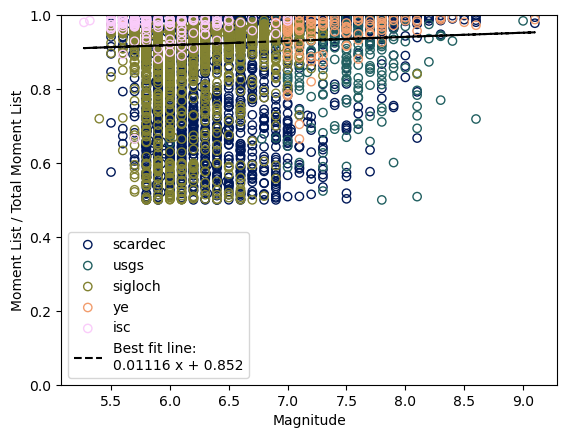

In [25]:
for dataset in unique_datasets:
	subset = db[db['dataset'] == dataset]
	plt.scatter(subset['magnitude'], subset['moment_list']/subset['total_moment_list'], label=dataset, edgecolor=dataset_colors[dataset], facecolor='none')
# Fit a line of best fit

drop_na = db.dropna(subset = ['magnitude', 'moment_list', 'total_moment_list'])
#drop_na = drop_na[drop_na['magnitude'] < 7]

z = np.polyfit(drop_na['magnitude'], drop_na['moment_list']/drop_na['total_moment_list'], 1)
p = np.poly1d(z)
plt.plot(drop_na['magnitude'], p(drop_na['magnitude']), linestyle='--', color='k', label = f'Best fit line: {p}')



plt.legend()
plt.xlabel('Magnitude')
plt.ylabel('Moment List / Total Moment List')
plt.ylim(0, 1)
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/ends/proportion_moment_cut_off.png')
plt.show()


In [26]:
from scipy.stats import spearmanr

db2 = db.copy() #db.dropna(subset=['moment_list', 'total_moment_list']).copy()
#db2 = db2[db2['magnitude'] < 7]
ratio = db2['moment_list'] / db2['total_moment_list']
spearman_corr, p_value = spearmanr(db2['magnitude'], ratio, nan_policy='omit')
print(f"Spearman correlation coefficient: {spearman_corr}, p-value: {p_value}")

Spearman correlation coefficient: 0.11957494975814235, p-value: 1.7328737575590995e-32


In [27]:
ratio

0        0.985735
1             NaN
2        0.974607
3        0.998804
4        0.968950
           ...   
11761    0.873997
11762    0.944638
11763    0.911677
11764    0.786632
11765    0.961532
Length: 11766, dtype: float64

In [28]:
np.mean(ratio)

0.9225738176643435

In [29]:
np.median(ratio)

nan

(array([ 174.,  211.,  176.,  212.,  225.,  200.,  235.,  434., 1615.,
        6306.]),
 array([0.50000063, 0.54999121, 0.59998178, 0.64997236, 0.69996293,
        0.74995351, 0.79994408, 0.84993466, 0.89992523, 0.94991581,
        0.99990638]),
 <BarContainer object of 10 artists>)

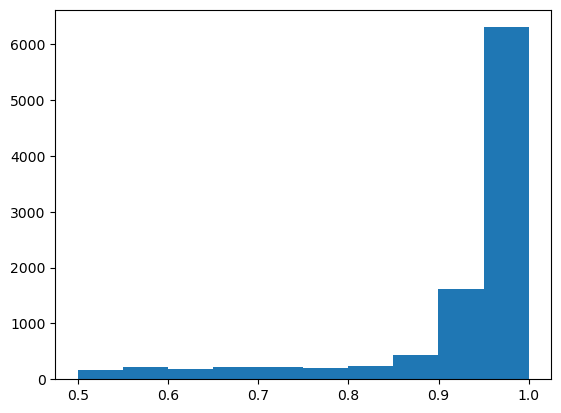

In [30]:
plt.hist(ratio)

(array([  64.,   31.,   24.,   20.,   35.,   30.,   43.,   40.,   37.,
          61.,   40.,   26.,   27.,   36.,   47.,   34.,   43.,   44.,
          42.,   49.,   45.,   49.,   44.,   44.,   43.,   37.,   38.,
          46.,   42.,   37.,   41.,   53.,   43.,   47.,   51.,   74.,
          68.,   79.,   98.,  115.,  141.,  197.,  267.,  405.,  605.,
         955., 1285., 1150., 1000., 1916.]),
 array([0.50000063, 0.50999875, 0.51999686, 0.52999498, 0.53999309,
        0.54999121, 0.55998932, 0.56998744, 0.57998555, 0.58998367,
        0.59998178, 0.6099799 , 0.61997801, 0.62997613, 0.63997424,
        0.64997236, 0.65997047, 0.66996859, 0.6799667 , 0.68996482,
        0.69996293, 0.70996105, 0.71995916, 0.72995728, 0.73995539,
        0.74995351, 0.75995162, 0.76994974, 0.77994785, 0.78994597,
        0.79994408, 0.8099422 , 0.81994031, 0.82993843, 0.83993654,
        0.84993466, 0.85993277, 0.86993089, 0.879929  , 0.88992712,
        0.89992523, 0.90992335, 0.91992146, 0.92991958, 

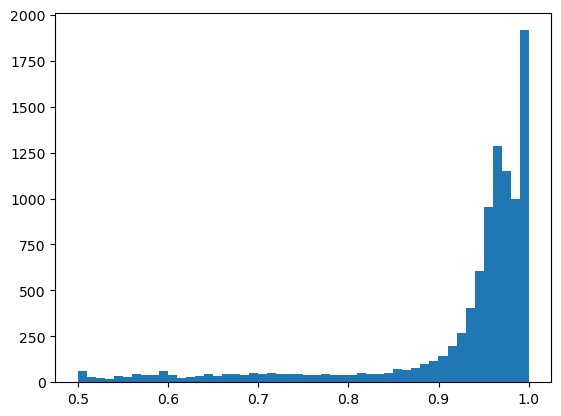

In [31]:
plt.hist(db['moment_list']/db['total_moment_list'], bins = 50)

In [32]:
len(db)

11766

In [33]:
len(db[db['moment_list']/db['total_moment_list'] < 1])

9788

In [34]:
len(db[db['moment_list']/db['total_moment_list'] < 0.9])

1868

In [35]:
print(list(db[db['moment_list']/db['total_moment_list'] < 0.6].name))

['20111006_1112', '20150918_1559', '20030106_2343', '20050119_0611', '20220926_0959', '20210218_1530', '20210218_1530', '19950625_0210', '19930712_1317', '20050124_0416', '20210616_0443', '20210616_0443', '20140401_2346', '20141113_1024', '20181021_0140', '20071226_2204', '19970706_2013', '19970706_2013', '20190714_0910', '20190714_0910', '19920626_1132', '20151108_1647', '20021010_1050', '20021010_1050', '20190126_0812', '19970808_2227', '19970808_2227', '20101220_1841', '19950529_0729', '20020326_0345', '20110319_0122', '20060815_0305', '20060815_0305', '20030628_1529', '20010614_2331', '20141028_0315', '20141028_0315', '19920720_0746', '19970728_0646', '20080419_0312', '20010704_1747', '20150524_1438', '20150524_1438', '19961209_1128', '19961209_1128', '19940603_2106', '19940603_2106', '20181205_0418', '20110113_1616', '20110113_1616', '20030127_1756', '20060506_1826', '20060506_1826', '20000828_1505', '20140310_0518', '20140310_0518', '20160607_1915', '20020219_0035', '20020219_003

In [36]:
magnitudes = []
events = []
datasets = []
depths = []
moment_list = []
total_moment_list = []

for i, row in combined.iterrows():
    
    if row.isc not in ['0', 0]:
        momentrate, time = load_isc(row['isc'])
        momentrate = momentrate[0]
        momentrate[momentrate < 0] = 0
        detected_end_time, detected_end, detected_start_time, detected_start, moment, total_moment = find_end_stf(momentrate, time)
        print(detected_end_time)
        time = time - detected_start_time # shift to start STF at zero
        # moment_list.append(moment)
        # total_moment_list.append(total_moment)
        # magnitudes.append(mag)
        # events.append(row.event)
        # datasets.append('isc')
        # depths.append(depth)
        break



9.600000000000001


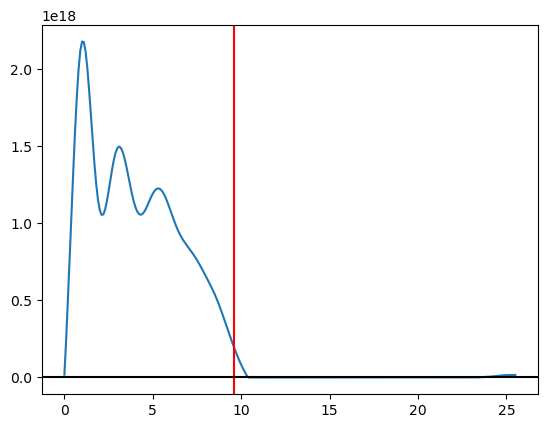

In [37]:
plt.plot(time, momentrate)
plt.axvline(detected_end_time, color='r')
plt.axhline(0, color='k')

In [38]:
moment/total_moment

0.9895297132770212